<h1><center>Support Vector Machines</center></h1>
<center>Author: Apoorv Sharma</center>


The function we are trying to optimize is defined as follows:

$$
min_{a \in \mathbb{R}} F(\alpha) = \frac{1}{n} \sum_{i=1}^n \ell(y_i, (K\alpha)_i) + \lambda \alpha^T K \alpha
$$

Substituting in the loss function, we obtain:

$$
min_{a \in \mathbb{R}} F(\alpha) = \frac{1}{n} \sum_{i=1}^n \left( max\{ 0, 1-yt \} \right)^2 + \lambda \alpha^T K \alpha
$$

Thus, taking the derivative, we get:

$$
\nabla F(\alpha) = -\frac{2}{n} \sum_{i=1}^n y_iK_i \left( max\{ 0, 1-y_i^TK_i\alpha \} \right) + 2\lambda K \alpha
$$

The above can be written as a peicewise equation

$$
\nabla F(\alpha) = 
\begin{cases}
    -\frac{2}{n} \sum_{i=1}^n y_iK_i \left(1-y_i^TK_i\alpha \right) + 2\lambda K \alpha,& \text{if } y_i(K\alpha)_i > 0\\
    0,              & \text{otherwise}
\end{cases}
$$



In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_digits
from sklearn.preprocessing import normalize
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt
%matplotlib inline

We define the base class, `KernelSVM`. This class contains the fast gradient descent code, objective function and gradient of the objective.

The children classes define the specific kernel functions required. Here we define 3 main kernels:


1.   Linear Kernel: Implemented using `LinearSVM` 
2.   Polynomial Kernel: Implemented using `PolySVM`
3.   Gaussian/Radial Bias Function (RBF) Kernel: Implemented using `GaussianSVM`



In [2]:
class KernelSVM:
    def __init__(self, lambda_, X_train, y_train, max_iters_=300):
        self.lambda_ = lambda_
        
        self.X = X_train
        self.y = y_train
        
        self.n, self.d = X_train.shape
                
        self.decay_rate = 0.7
        self.prop_constant = 0.2

        self.max_iters = max_iters_
    
    @abstractmethod
    def kernel(self, x, y):
        pass
    
    def computegram(self, X, Z):
        gram = self.kernel(X, Z)
        return gram
    
    def kerneleval(self, Y):
        keval = np.zeros((self.n, 1))

        for i in range(self.n):
            x = self.X[i, :]
            keval[i, 0] = self.kernel(x, Y)

        return keval
    
    def objective(self, alpha):
        K_alpha = self.gram @ alpha
        reg_val = self.lambda_ * (alpha.T @ K_alpha)
        condition_exp = 1 - np.multiply(self.y, K_alpha)
        condition_exp[condition_exp < 0] = 0  # equivalent to max(0, condition_exp)
        condition_exp = np.square(condition_exp) # condition_exp ^ 2
        
        return np.mean(condition_exp) + reg_val

    def computegrad(self, alpha):
        K_alpha = np.dot(self.gram, alpha)
        reg_val = (2 * self.lambda_ * K_alpha)

        delta_value = -2.0 * self.y * (self.gram)
        condition_expression = self.y * (K_alpha)
        condition_expression[condition_expression > 1] = 0

        loss = delta_value * (1 - condition_expression)
        loss = loss.sum(axis=1)
        
        grad = (1.0/self.n) * loss + reg_val
        return grad

    def backtracking(self, eta_init, beta, grad):
        
        step_size = eta_init
        
        gradient = grad
        objective_prior = self.objective(beta)
        gradient_norm = np.sum(np.square(gradient))
            
        for _ in range(self.max_iters):
            beta_posterior = beta - step_size * gradient
            objective_posterior = self.objective(beta_posterior)

            minimum_move = objective_prior - self.prop_constant * step_size * gradient_norm

            if objective_posterior <= minimum_move:
                return step_size
            else:
                step_size *= self.decay_rate
            
        return step_size
    
    def fastgradalgo(self, alpha_init, epsilon, eta_init):

        beta = alpha_init
        theta = alpha_init
        step_size = eta_init
        
        objective_log = [self.objective(beta)]
        betas = [beta]
        
        for iter in range(self.max_iters):
            grad_beta = self.computegrad(beta)

            # print(f'Iteration: {iter} Grad Norm: {np.linalg.norm(grad_beta)}')
            # print(f'Iteration: {iter} Obj: {objective_log[-1]}')

            if np.linalg.norm(grad_beta) <= epsilon:
                return beta, objective_log, betas
            
            step_size = self.backtracking(step_size, beta, grad_beta)
            grad_theta = self.computegrad(theta)
            
            beta_new = theta - step_size * grad_theta
            theta = beta_new + (iter / (iter + 3)) * (beta_new - beta)
            beta = beta_new
            objective_log.append(self.objective(beta))
            betas.append(beta)
        
        return beta, objective_log, betas
    
    def train(self, epsilon=1):
        alpha = np.zeros(self.n)
        
        eta_init = (1/(max(np.linalg.eigvals(1/self.n * self.gram.dot(self.gram.T))) + self.lambda_)).real
        # eta_init = 0.1
        # print(f'Initial Learning Rate: {eta_init:.10f}')
        
        beta, objvals, betas = self.fastgradalgo(alpha, epsilon, eta_init)
        self.alpha = beta

        # print(f'Done after {len(objvals)} iterations')
        return betas, objvals
    
    def predict(self, X_test):
        weights = self.alpha
        gram_test = self.computegram(self.X, X_test)

        # print(np.sum(weights[:, np.newaxis] * gram_test, axis=0))

        y_pred = np.sign(np.sum(weights[:, np.newaxis] * gram_test, axis=0)).reshape(1, -1)[0]
        return y_pred

class PolySVM(KernelSVM):
    def __init__(self, lambda_, X_train, y_train, offset_, exponent_, max_iters_=300):
        super().__init__(lambda_, X_train, y_train, max_iters_)

        self.offset = offset_
        self.exponent = exponent_

        self.gram = self.computegram(self.X, self.X)
    
    def kernel(self, x, y):
        return ((x @ y.T) + self.offset) ** self.exponent

class LinearSVM(KernelSVM):
    def __init__(self, lambda_, X_train, y_train, max_iters_=300):
        super().__init__(lambda_, X_train, y_train, max_iters_)

        self.gram = self.computegram(self.X, self.X)
    
    def kernel(self, x, y):
        return (x @ y.T)

class GaussianSVM(KernelSVM):
    def __init__(self, lambda_, X_train, y_train, gamma_, max_iters_=300):
        super().__init__(lambda_, X_train, y_train, max_iters_)

        self.gamma = gamma_
        self.gram = self.computegram(self.X, self.X)
    
    def kernel(self, x, y):
        return np.exp(self.gamma * np.square(x[:, np.newaxis] - y).sum(axis=2))


In [3]:
def acc(y_true, y_pred):
    return np.mean(y_pred == y_true)

Initial Setting for hyperparameters

In [4]:
B, P = 1, 7
LAMBDA = 10.0

We now load and return the digits dataset

In [5]:
digits = load_digits()
X = digits.data
y = digits.target

unique_digits = np.unique(y)

<Figure size 432x288 with 0 Axes>

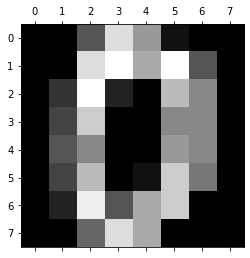

In [6]:
plt.gray()
plt.matshow(digits.images[0])

In [7]:
X = normalize(X, norm='l2', axis=1)

In [8]:
np.linalg.norm(X[0])

1.0

We now split the dataset into test and train sets. Here the stratisfied approach has been used in order to balance the occurences of the digits in the test and train data

In [9]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
# X, X_test, y, y_test = train_test_split(X, y, test_size=0.2)

We now format the data so we create 10 'one vs rest' classifiers; one for each digit present in the dataset (0 - 9)

We create a map to keep track of the information for each digit. The keys in the map are the interger of the digit we are trying to classify.



In [10]:
digits_dataset_dict = {}
for digit in unique_digits:
    y_d = np.where(y == digit, 1, -1)
    
    digits_dataset_dict[int(digit)] = {}
    digits_dataset_dict[int(digit)]['y'] = y_d

We train each of the *one vs rest* classifiers and store the model, iterates and objective values in the map

In [11]:
for digit, digit_info in digits_dataset_dict.items():
    print(f'Starting: {digit}')
    digit_info['model'] = PolySVM(LAMBDA, X, digit_info['y'], B, P)
    digit_info['iterates'], digit_info['obj'] = digit_info['model'].train()

    y_preds = digit_info['model'].predict(X_test)
    y_d = np.where(y_test == digit, 1, -1)

    print(np.where(y_preds == 1))
    print()

Starting: 0
(array([172, 181, 302, 355]),)

Starting: 1
(array([], dtype=int64),)

Starting: 2
(array([], dtype=int64),)

Starting: 3
(array([], dtype=int64),)

Starting: 4
(array([ 27, 184]),)

Starting: 5
(array([], dtype=int64),)

Starting: 6
(array([117, 202, 205, 233, 296, 329, 341, 352]),)

Starting: 7
(array([55]),)

Starting: 8
(array([], dtype=int64),)

Starting: 9
(array([], dtype=int64),)



The following cell blocks show the decrease of the objective function vs the number of iterations

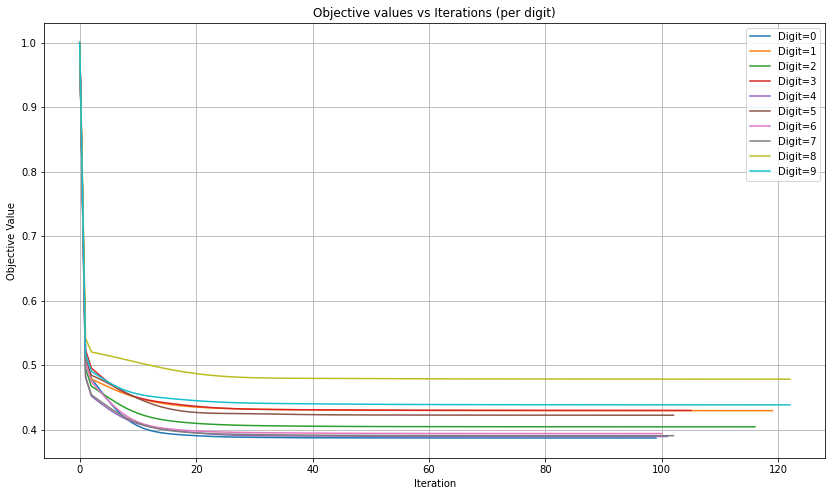

In [12]:
def plot_objectives(digits_dataset_dict):
    
    row, col = 2, 5
    i = 0
    f = plt.figure(figsize=(14, 8))
    for digit, digit_info in digits_dataset_dict.items():
        # Debug, plot figure
        i += 1
        plt.plot(np.array(range(len(digit_info['obj']))), digit_info['obj'], label=f'Digit={digit}')
        
    plt.title(f'Objective values vs Iterations (per digit)')
    plt.xlabel('Iteration')
    plt.ylabel('Objective Value')

    plt.savefig(f'images_c1.png')
    plt.legend()
    plt.grid()
    plt.show(block=True)

plot_objectives(digits_dataset_dict)

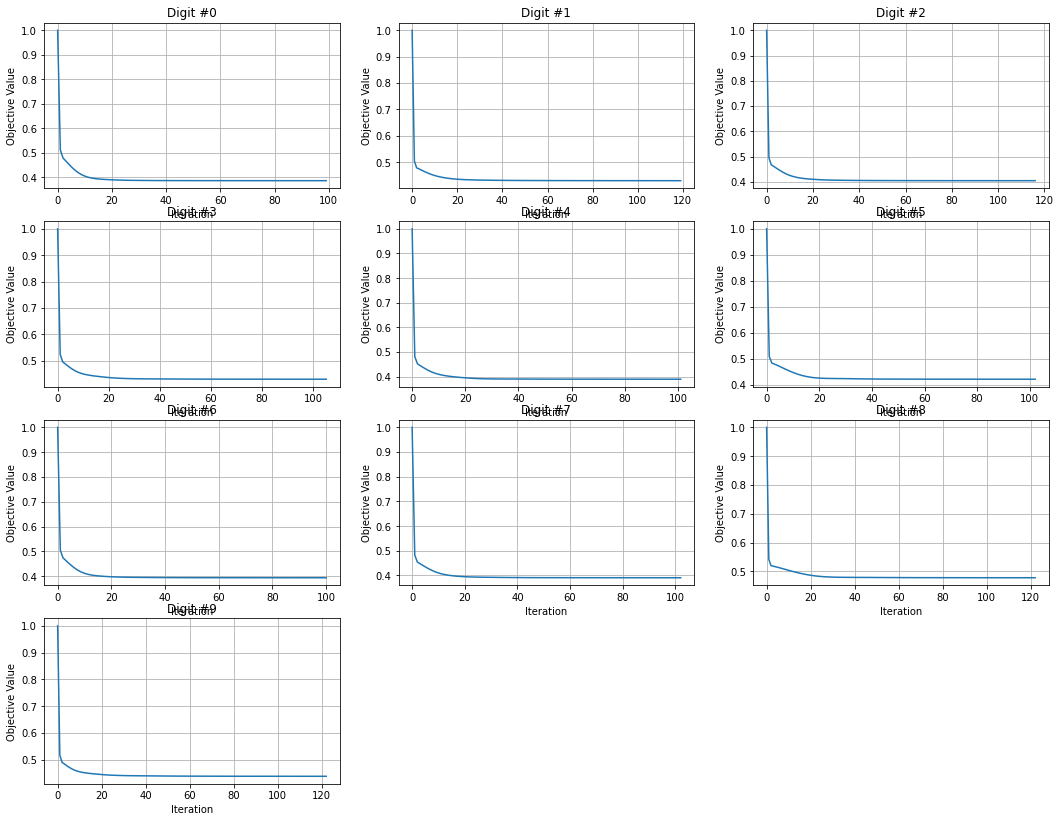

In [13]:
def plot_objectives_subplots(digits_dataset_dict):
    
    row, col = 4, 3
    i = 0
    f = plt.figure(figsize=(18, 14))
    for digit, digit_info in digits_dataset_dict.items():
        # Debug, plot figure
        i += 1
        f.add_subplot(row, col, i)
        plt.plot(np.array(range(len(digit_info['obj']))), digit_info['obj'])
        
        plt.title(f'Digit #{digit}')
        plt.xlabel('Iteration')
        plt.ylabel('Objective Value')
        plt.grid()

    plt.savefig(f'objective_subplots.png')
    plt.show(block=True)

plot_objectives_subplots(digits_dataset_dict)

We now do 5-fold cross validation to find the optimal value of $\lambda$

For each of the 10 *one vs rest* classifiers, we train the model using the specified $\lambda$ value, for each of the 5 splits we obtain

In [14]:
N = 5
kf = KFold(N, True)

/anaconda/envs/py37_default/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [15]:
lambda_vals = np.logspace(-2, 1.4, 10)

digit_scores = []
for digit, digit_info in digits_dataset_dict.items():
    print(f"Starting Digit: {digit}")
    scores = np.zeros((len(lambda_vals), N))

    for i, lambda_val in enumerate(lambda_vals):
        print(f"\tStarting lambda: {lambda_val}")
        for j, (train_index, test_index) in enumerate(kf.split(X)):

            X_digit_train, X_digit_test = X[train_index], X[test_index]
            y_digit_train, y_digit_test = digit_info['y'][train_index], digit_info['y'][test_index]

            # Train the model using the current lambda value
            model = PolySVM(lambda_val, X_digit_train, y_digit_train, B, P)
            alphas, objs = model.train()

            # Predict using the validation test data
            y_preds = model.predict(X_digit_test)
            y_d = np.where(y_digit_test == digit, 1, -1)

            # Generate the accuracy score, and add to an array
            scores[i, j] = acc(y_d, y_preds)
        print(f'\t\tAccuracy: {scores[i, :]}')
    
    digit_scores.append(scores)

digit_scores = np.array(digit_scores)

Starting Digit: 0
	Starting lambda: 0.01
		Accuracy: [1. 1. 1. 1. 1.]
	Starting lambda: 0.023865897868585808
		Accuracy: [1. 1. 1. 1. 1.]
	Starting lambda: 0.056958108107376865
		Accuracy: [1. 1. 1. 1. 1.]
	Starting lambda: 0.13593563908785256
		Accuracy: [1. 1. 1. 1. 1.]
	Starting lambda: 0.324422607917163
		Accuracy: [1. 1. 1. 1. 1.]
	Starting lambda: 0.774263682681127
		Accuracy: [1. 1. 1. 1. 1.]
	Starting lambda: 1.8478497974222907
		Accuracy: [1. 1. 1. 1. 1.]
	Starting lambda: 4.410059454176737
		Accuracy: [1. 1. 1. 1. 1.]
	Starting lambda: 10.525002852777327
		Accuracy: [0.99652778 0.99652778 0.99303136 1.         1.        ]
	Starting lambda: 25.118864315095795
		Accuracy: [1. 1. 1. 1. 1.]
Starting Digit: 1
	Starting lambda: 0.01
		Accuracy: [0.91319444 0.91319444 0.90592334 0.8815331  0.87804878]
	Starting lambda: 0.023865897868585808
		Accuracy: [0.90972222 0.91319444 0.8815331  0.89547038 0.89198606]
	Starting lambda: 0.056958108107376865
		Accuracy: [0.90277778 0.88888889 0.

In [16]:
for i, digit_score in enumerate(digit_scores):
    lambda_scores = digit_score.mean(axis=1) # Average score from the N-fold values
    digits_dataset_dict[i]['lambda_opt'] = lambda_vals[np.argmax(lambda_scores)] #Best average

Following is the optimal $\lambda$ for each of the *one vs rest* classifiers

In [17]:
for digit, digit_info in digits_dataset_dict.items():
    print(f'Digit {digit} has optimal lambda = {digit_info["lambda_opt"]:.3f}')

Digit 0 has optimal lambda = 0.010
Digit 1 has optimal lambda = 10.525
Digit 2 has optimal lambda = 0.010
Digit 3 has optimal lambda = 0.010
Digit 4 has optimal lambda = 0.010
Digit 5 has optimal lambda = 0.010
Digit 6 has optimal lambda = 0.010
Digit 7 has optimal lambda = 0.010
Digit 8 has optimal lambda = 0.010
Digit 9 has optimal lambda = 0.010


We now re-train each of the classifers using the optimal $\lambda$ value found

In [18]:
digit_classifier_acc = []

for digit, digit_info in digits_dataset_dict.items():
    lambda_opt = digit_info['lambda_opt']
    digit_info['model_opt'] = PolySVM(lambda_opt, X, digit_info['y'], B, P)
    digit_info['iterates_opt'], digit_info['obj_opt'] = digit_info['model_opt'].train()

    y_preds = digit_info['model_opt'].predict(X_test)
    y_d = np.where(y_test == digit, 1, -1)

    digit_acc = acc(y_d, y_preds)
    digit_classifier_acc.append((digit, digit_acc))

    print(f'Digit {digit} classifier has accuracy: {digit_acc:.3f}')

Digit 0 classifier has accuracy: 0.900
Digit 1 classifier has accuracy: 0.900
Digit 2 classifier has accuracy: 0.903
Digit 3 classifier has accuracy: 0.897
Digit 4 classifier has accuracy: 0.900
Digit 5 classifier has accuracy: 0.897
Digit 6 classifier has accuracy: 0.900
Digit 7 classifier has accuracy: 0.900
Digit 8 classifier has accuracy: 0.903
Digit 9 classifier has accuracy: 0.900


Out of all the 10 *one vs rest* classifiers, we find the one that has the highest accuracy and report the misclassification error for this particular classifier

In [19]:
best_digit_classifier, best_digit_acc = max(digit_classifier_acc, key = lambda x: x[1])

In [20]:
print(f'Best classifier is: {best_digit_classifier} having mis-classification error of: {1-best_digit_acc:.2f}')

Best classifier is: 2 having mis-classification error of: 0.10


## Performance of Kernel functions

We test out various choices for some of the parameters and report the accuracy for each model that we train

In [21]:
y_train_best_digit = digits_dataset_dict[best_digit_classifier]['y']
y_test_best_digit = np.where(y_test == best_digit_classifier, 1, -1)

In [22]:
def get_model_accuracy(model, y_test):
    model.train()
    y_preds = model.predict(X_test)
    accuracy = acc(y_test, y_preds)

    return accuracy

Linear Model

In [23]:
model = LinearSVM(LAMBDA, X, y_train_best_digit)
get_model_accuracy(model, y_test_best_digit)

0.9027777777777778

Polynomial Models

In [24]:
poly_bias = [0, 1]
poly_offsets = [2, 5, 9, 14, 19]

for p in poly_offsets:
    for b in poly_bias:
        model = PolySVM(LAMBDA, X, y_train_best_digit, offset_=b, exponent_=p)
        accuracy = get_model_accuracy(model, y_test_best_digit)
        print(f'Polynomial Model: b={b}, p={p} gets accuracy: {accuracy:.3f}')

Polynomial Model: b=0, p=2 gets accuracy: 0.903
Polynomial Model: b=1, p=2 gets accuracy: 0.969
Polynomial Model: b=0, p=5 gets accuracy: 0.903
Polynomial Model: b=1, p=5 gets accuracy: 0.903
Polynomial Model: b=0, p=9 gets accuracy: 0.903
Polynomial Model: b=1, p=9 gets accuracy: 0.903
Polynomial Model: b=0, p=14 gets accuracy: 0.953
Polynomial Model: b=1, p=14 gets accuracy: 0.903
Polynomial Model: b=0, p=19 gets accuracy: 0.950
Polynomial Model: b=1, p=19 gets accuracy: 0.903


Gaussian/RBF Models

In [25]:
rbf_gammas = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 2e2]

for g in rbf_gammas:
    model = GaussianSVM(LAMBDA, X, y_train_best_digit, gamma_=g)
    accuracy = get_model_accuracy(model, y_test_best_digit)

    print(f'Gaussian Model: gamma={g} gets accuracy: {accuracy:.3f}')

Gaussian Model: gamma=1e-09 gets accuracy: 0.903
Gaussian Model: gamma=1e-08 gets accuracy: 0.903
Gaussian Model: gamma=1e-07 gets accuracy: 0.903
Gaussian Model: gamma=1e-06 gets accuracy: 0.903
Gaussian Model: gamma=1e-05 gets accuracy: 0.903
Gaussian Model: gamma=0.0001 gets accuracy: 0.903
Gaussian Model: gamma=0.001 gets accuracy: 0.903
Gaussian Model: gamma=0.01 gets accuracy: 0.903
Gaussian Model: gamma=0.1 gets accuracy: 0.903
Gaussian Model: gamma=1 gets accuracy: 0.589
Gaussian Model: gamma=100.0 gets accuracy: 0.889
Gaussian Model: gamma=200.0 gets accuracy: 0.889
